In [1]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
cd gdrive

/content/gdrive


In [3]:
cd MyDrive

/content/gdrive/MyDrive


In [4]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xghezaon
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xghezaon
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=6bea2e681d6fc66fa85e42c8347a12e5be1254e1c578d2294037cc0862cf761b
  Stored in directory: /tmp/pip-ephem-wheel-cache-bih3a9uv/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [5]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import clip
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [6]:
cnn_data_folder = 'cnn_dataset'

In [7]:
# Step 7: Load and Preprocess Images for Nature Classification
class ImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images = []
        labels = []
        for class_label, class_name in enumerate(os.listdir(self.data_folder)):
            class_folder = os.path.join(self.data_folder, class_name)
            if not os.path.isdir(class_folder):
                continue
            for file_name in os.listdir(class_folder):
                file_path = os.path.join(class_folder, file_name)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (224, 224))  # Resize image to fit CLIP model input shape
                label = class_label
                images.append(image)
                labels.append(label)
        return np.array(images), np.array(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Define the transformation to normalize and convert image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
# Load the fine-tuned CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

In [11]:
#  Split the dataset into train, validation, and test sets
cnn_data_folder = 'cnn_dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
dataset = ImageDataset(cnn_data_folder, transform=transform)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_samples = len(dataset)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

train_set, temp_set = train_test_split(dataset, train_size=num_train)
val_set, test_set = train_test_split(temp_set, train_size=num_val)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [12]:
# Define the classification head
num_classes = len(set(dataset.labels))
classifier_head = nn.Linear(512, num_classes).to(device)

In [13]:
# Define the optimizer and loss function
optimizer = optim.Adam(classifier_head.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
# Train the classification head
num_epochs = 100
for epoch in range(num_epochs):
    classifier_head.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)

        # Convert the data type of image_features to match the classifier's weight matrix
        image_features = image_features.to(classifier_head.weight.dtype)

        optimizer.zero_grad()
        logits = classifier_head(image_features)

        # Convert logits data type to torch.float32 for softmax
        logits = logits.to(torch.float32)

        loss = criterion(logits, labels)  # No need to convert labels to torch.long data type
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_labels = logits.max(1)
        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate accuracy
    accuracy = total_correct / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Accuracy: {accuracy:.4f}")


Epoch [1/100] - Loss: 24.7738 - Accuracy: 0.7350
Epoch [2/100] - Loss: 19.7557 - Accuracy: 0.8043
Epoch [3/100] - Loss: 17.9082 - Accuracy: 0.8179
Epoch [4/100] - Loss: 16.7418 - Accuracy: 0.8429
Epoch [5/100] - Loss: 15.8821 - Accuracy: 0.8550
Epoch [6/100] - Loss: 15.4141 - Accuracy: 0.8529
Epoch [7/100] - Loss: 14.7263 - Accuracy: 0.8679
Epoch [8/100] - Loss: 14.3261 - Accuracy: 0.8664
Epoch [9/100] - Loss: 13.8878 - Accuracy: 0.8757
Epoch [10/100] - Loss: 13.6610 - Accuracy: 0.8771
Epoch [11/100] - Loss: 13.3734 - Accuracy: 0.8793
Epoch [12/100] - Loss: 13.0265 - Accuracy: 0.8821
Epoch [13/100] - Loss: 12.7824 - Accuracy: 0.8879
Epoch [14/100] - Loss: 12.5594 - Accuracy: 0.8900
Epoch [15/100] - Loss: 12.2828 - Accuracy: 0.8979
Epoch [16/100] - Loss: 12.1541 - Accuracy: 0.8964
Epoch [17/100] - Loss: 12.0887 - Accuracy: 0.8964
Epoch [18/100] - Loss: 11.8951 - Accuracy: 0.8971
Epoch [19/100] - Loss: 11.5670 - Accuracy: 0.9036
Epoch [20/100] - Loss: 11.4439 - Accuracy: 0.9043
Epoch [21

In [15]:
# Step 9: Model Evaluation for Nature Classification
nature_pred = []
nature_labels = []
classifier_head.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        image_features = model.encode_image(images)

        # Convert the data type of image_features to match the classifier's weight matrix
        image_features = image_features.to(classifier_head.weight.dtype)

        logits = classifier_head(image_features)
        pred = logits.argmax(dim=-1).cpu().numpy()
        nature_pred.extend(pred)
        nature_labels.extend(labels.cpu().numpy())

nature_accuracy = accuracy_score(nature_labels, nature_pred)
nature_precision = precision_score(nature_labels, nature_pred, average='weighted')
nature_recall = recall_score(nature_labels, nature_pred, average='weighted')
nature_f1_score = f1_score(nature_labels, nature_pred, average='weighted')

print("Nature Accuracy:", nature_accuracy)
print("Nature Precision:", nature_precision)
print("Nature Recall:", nature_recall)
print("Nature F1-score:", nature_f1_score)


Nature Accuracy: 0.9492857142857143
Nature Precision: 0.9494514443156722
Nature Recall: 0.9492857142857143
Nature F1-score: 0.9492867234011351


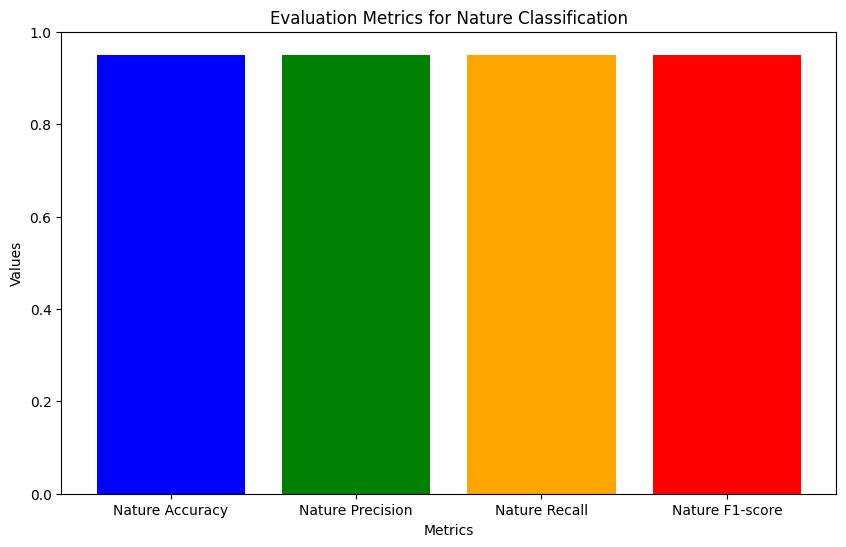

In [16]:
import matplotlib.pyplot as plt
# Step 14: Visualize evaluation metrics
metrics_names = ['Nature Accuracy', 'Nature Precision', 'Nature Recall', 'Nature F1-score']
metrics_values = [nature_accuracy, nature_precision, nature_recall, nature_f1_score]

plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics for Nature Classification')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1
plt.show()

Nature Accuracy: 0.9492857142857143


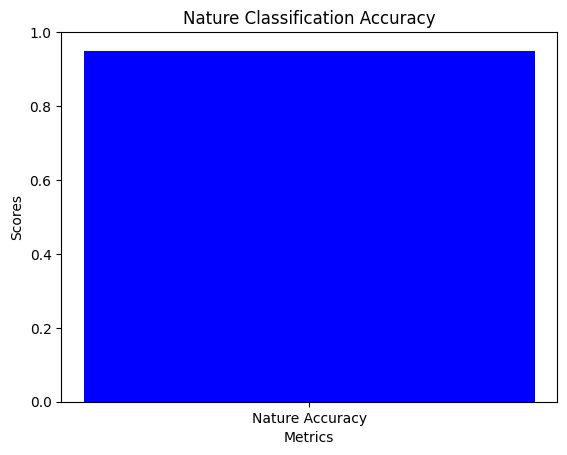

In [19]:
nature_pred = []
nature_labels = []
classifier_head.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        image_features = model.encode_image(images)

        # Convert the data type of image_features to match the classifier's weight matrix
        image_features = image_features.to(classifier_head.weight.dtype)

        logits = classifier_head(image_features)
        pred = logits.argmax(dim=-1).cpu().numpy()
        nature_pred.extend(pred)
        nature_labels.extend(labels.cpu().numpy())

nature_accuracy = accuracy_score(nature_labels, nature_pred)

print("Nature Accuracy:", nature_accuracy)

# Plotting the accuracy as a bar
plt.bar(['Nature Accuracy'], [nature_accuracy], color='blue')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Nature Classification Accuracy')
plt.ylim(0.0, 1.0)
plt.show()

Epoch [1/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [2/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [3/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [4/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [5/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [6/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [7/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [8/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [9/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [10/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [11/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [12/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [13/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [14/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [15/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [16/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [17/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [18/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [19/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [20/100] - Loss: 7.0141 - Accuracy: 0.9471
Epoch [21/100] - Loss: 7.0141

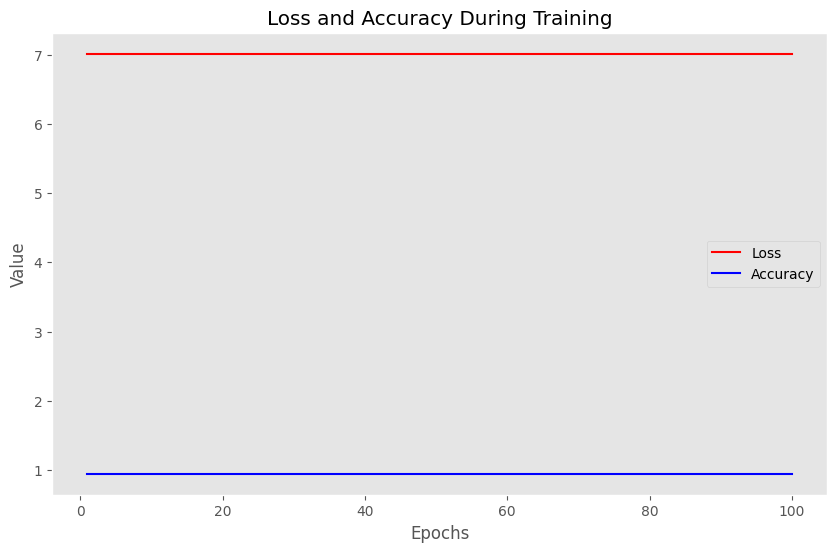

In [24]:
# Inside the training loop
for epoch in range(num_epochs):
    # ... (other training code)

    # Calculate accuracy
    accuracy = total_correct / total_samples

    # Append loss and accuracy to their respective lists
    loss_values.append(total_loss)
    accuracy_values.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Accuracy: {accuracy:.4f}")

# After the training loop
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), loss_values, label='Loss', color='red')
plt.plot(range(1, num_epochs+1), accuracy_values, label='Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Loss and Accuracy During Training')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Step 10: Save Nature Model
# Save the fine-tuned classifier head
nature_model_file = 'nature--model.pt'
torch.save(classifier_head.state_dict(), nature_model_file)
print("Nature Model saved successfully.")

Nature Model saved successfully.
